# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create training set and define training dataloader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I choose the transforms above because naturally pytorch work with tensors not with raw images. It is acually a efficiant way to do the calculations. First line converts the image into a Pytorch tensor and the second line normalizes the pixel values to a range of [-1, 1].

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


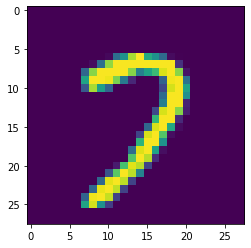

7


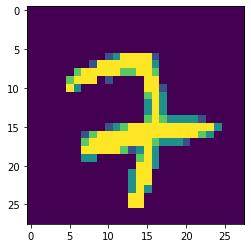

6


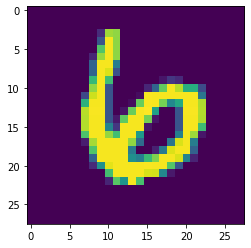

6


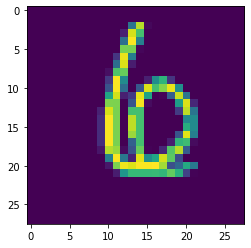

5


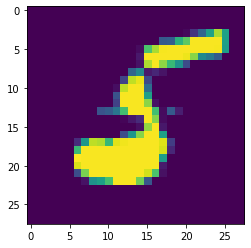

In [6]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
# Define network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
net = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
# Move network and data to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [10]:
# Train network
def train(net, train_loader, criterion, optimizer, device, epochs, print_every):
    net.train() # Set network to training mode
    losses = [] # Initialize losses for plotting
    running_loss = 0.0
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU if available

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

            if i % print_every == print_every-1:
                print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
                # Collect running loss for plotting
                losses.append(running_loss/print_every)
                running_loss = 0.0
    return losses

In [11]:
train_loss = train(net, train_loader, criterion, optimizer, device, epochs=20, print_every=100)
#train(net, train_loader, criterion, optimizer, device, epochs=5, print_every=1000)
print('Finished Training')

[1,   100] loss: 0.932
[1,   200] loss: 0.466
[1,   300] loss: 0.396
[1,   400] loss: 0.341
[1,   500] loss: 0.312
[1,   600] loss: 0.303
[1,   700] loss: 0.281
[1,   800] loss: 0.274
[1,   900] loss: 0.267
[2,   100] loss: 0.316
[2,   200] loss: 0.223
[2,   300] loss: 0.224
[2,   400] loss: 0.217
[2,   500] loss: 0.222
[2,   600] loss: 0.247
[2,   700] loss: 0.211
[2,   800] loss: 0.205
[2,   900] loss: 0.216
[3,   100] loss: 0.261
[3,   200] loss: 0.198
[3,   300] loss: 0.181
[3,   400] loss: 0.186
[3,   500] loss: 0.176
[3,   600] loss: 0.173
[3,   700] loss: 0.182
[3,   800] loss: 0.175
[3,   900] loss: 0.188
[4,   100] loss: 0.215
[4,   200] loss: 0.149
[4,   300] loss: 0.171
[4,   400] loss: 0.159
[4,   500] loss: 0.153
[4,   600] loss: 0.160
[4,   700] loss: 0.167
[4,   800] loss: 0.153
[4,   900] loss: 0.137
[5,   100] loss: 0.206
[5,   200] loss: 0.163
[5,   300] loss: 0.151
[5,   400] loss: 0.137
[5,   500] loss: 0.147
[5,   600] loss: 0.143
[5,   700] loss: 0.160
[5,   800] 

Plot the training loss (and validation loss/accuracy, if recorded).

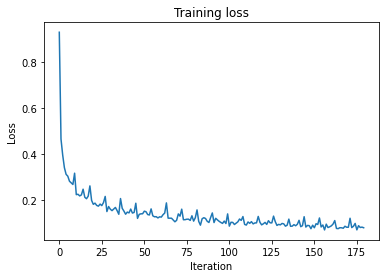

In [12]:
# Plot training loss
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Training loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

plot_losses(train_loss)

In [13]:
# Save model
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
# Load model
net = Net()
net.load_state_dict(torch.load(PATH))
net.eval() # Set network to evaluation mode

# Test network
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 97 %


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [15]:
# hyperparameter tuning
optimizer = optim.SGD(net.parameters(), lr=0.2, momentum=0.8)

# Move network and data to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [16]:
train_loss = train(net, train_loader, criterion, optimizer, device, epochs=20, print_every=100)

[1,   100] loss: 0.077
[1,   200] loss: 0.075
[1,   300] loss: 0.080
[1,   400] loss: 0.074
[1,   500] loss: 0.084
[1,   600] loss: 0.080
[1,   700] loss: 0.093
[1,   800] loss: 0.094
[1,   900] loss: 0.075
[2,   100] loss: 0.096
[2,   200] loss: 0.070
[2,   300] loss: 0.079
[2,   400] loss: 0.078
[2,   500] loss: 0.069
[2,   600] loss: 0.095
[2,   700] loss: 0.081
[2,   800] loss: 0.075
[2,   900] loss: 0.093
[3,   100] loss: 0.097
[3,   200] loss: 0.079
[3,   300] loss: 0.070
[3,   400] loss: 0.077
[3,   500] loss: 0.072
[3,   600] loss: 0.074
[3,   700] loss: 0.077
[3,   800] loss: 0.076
[3,   900] loss: 0.081
[4,   100] loss: 0.093
[4,   200] loss: 0.075
[4,   300] loss: 0.081
[4,   400] loss: 0.073
[4,   500] loss: 0.069
[4,   600] loss: 0.087
[4,   700] loss: 0.069
[4,   800] loss: 0.080
[4,   900] loss: 0.075
[5,   100] loss: 0.109
[5,   200] loss: 0.078
[5,   300] loss: 0.072
[5,   400] loss: 0.068
[5,   500] loss: 0.064
[5,   600] loss: 0.068
[5,   700] loss: 0.073
[5,   800] 

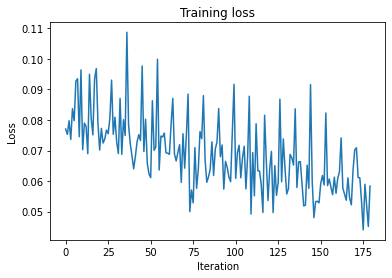

In [17]:
plot_losses(train_loss)

## Saving your model
Using `torch.save`, save your model for future loading.

In [18]:
# Save model
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)